In [29]:
import orbipy as op
import numpy as np
import pickle
from scipy.optimize import bisect

from instruments import instruments

In [24]:
def calculate_next_point_with_same_jacoby_constant(correction, previous_state, cj, previous_alpha_degrees, dr, model):
    """
    Given a previous point on the contour line of the jacobi constant, find the next point on the same contour line (with the same energy/jacobi constant).
    :param previous_state: previous (or initial) state of hte contour line point
    :param cj: jacobi constant of the contour line
    :param previous_alpha_degrees: angle alpha in degrees, for approximating the direction
    :return: (state, alpha)
    """
    def find_alpha(alpha_degrees):
        """
        Given angle alpha, calculate the corresponding state (polar coordinates) and returns the difference between given jacobi constant and the calculated one
        """
        state = model.get_zero_state().copy()
        x = previous_state[0] + np.cos(np.radians(alpha_degrees))*dr
        z = previous_state[2] + np.sin(np.radians(alpha_degrees))*dr
        state[[0,2]] = x, z
        state[4] = previous_state[4]
        np.set_printoptions(precision=10)
        velocity = correction.calc_dv(0, state)
        state += velocity
        cj_new = model.jacobi(state)
        return cj - cj_new

    res = bisect(find_alpha, previous_alpha_degrees - 40, previous_alpha_degrees + 40,
        xtol=1e-6, maxiter=100,
        full_output=True)

    target_alpha_degrees = res[0]
    np.set_printoptions(precision=10)
    print(f"    cj = {cj}; alpha = {target_alpha_degrees}")
    r = model.get_zero_state().copy()
    x = previous_state[0] + np.cos(np.radians(target_alpha_degrees))*dr
    z = previous_state[2] + np.sin(np.radians(target_alpha_degrees))*dr
    vy = previous_state[4]
    r[[0, 2, 4]] = x, z, vy

    print(f"   resulted point: {r[:3]}")
    r += correction.calc_dv(0, r)

    return r, target_alpha_degrees

def calculate_contour_line_of_jakobi_constant(model, initial_state, alpha, dr):
    """
    Given initial state of the zvl, calculate the contour line.
    :param initial_state: usually a point, lying on the Zero Velocity Line
    :param alpha: initial alpha (0 for right side and negative velocity, 180 for left side and positive velocity)
    :return: array of states [ [x,z,vy], [x,z,vy], [x,z,vy], ... ]
    """
    Cj = model.jacobi(initial_state)

    contour = []

    current_state = initial_state.copy()
    current_alpha = alpha

    steps = 0
    while current_state[2] > 0:
        contour.append(current_state[[0, 2, 4]].tolist())

        left = op.eventSPL(model, Cj, accurate=False) # left side of the half of the horizontal lyapunov orbit
        right = op.eventSPL(model, Cj, accurate=False, left=False) # right side
        correction = op.border_correction(model, op.y_direction(), left, right, dv0=0.03, maxt=1000.)

        try:
            new_state, current_alpha = calculate_next_point_with_same_jacoby_constant(
                correction, current_state, Cj, current_alpha, dr, model
            )
        except (RuntimeError, ValueError) as e:
            print(f"Step {steps} failed: {e}")
            break

        steps += 1
        current_state = new_state

    return contour

In [27]:
zvl = np.load('../data/contour_points/zvl/zvl_4_sparse.npy')

model = op.crtbp3_model('Earth-Moon (default)', integrator=op.dopri5_integrator(), stm=True)
one_thousand_kms = (1 - model.L1) / 61.350
dr = 3 * one_thousand_kms

# prepare indices and alphas
indices = range(0, len(zvl))
alphas = [0, 180]

results = []

for index in indices:
    for alpha in alphas:
        print(f"Computing contour for ZVL index={index}, alpha={alpha}...")
        # build initial state from ZVL data
        initial_state = model.get_zero_state()
        initial_state[[0, 2]] = zvl[index][0], zvl[index][1]

        contour = calculate_contour_line_of_jakobi_constant(model, initial_state, alpha, dr)
        results.append(contour)

        with open("../data/contour_points/icm_contour_data_spl_2.pickle", 'wb') as f:
            pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Done.")

Computing contour for ZVL index=0, alpha=0...
Computing contour for ZVL index=0, alpha=180...
Computing contour for ZVL index=1, alpha=0...


/home/tka4nik/Workdir/diploma/project/.venv/lib64/python3.12/site-packages/scipy/integrate/_ode.py:431: UserWarning: dopri5: larger nsteps is needed
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


Step 0 failed: Borders unreachable
Computing contour for ZVL index=1, alpha=180...
Step 0 failed: Borders unreachable
Computing contour for ZVL index=2, alpha=0...
Step 0 failed: Borders unreachable
Computing contour for ZVL index=2, alpha=180...
Step 0 failed: Borders unreachable
Computing contour for ZVL index=3, alpha=0...
Step 0 failed: Borders unreachable
Computing contour for ZVL index=3, alpha=180...
Step 0 failed: Borders unreachable
Computing contour for ZVL index=4, alpha=0...
Step 0 failed: Borders unreachable
Computing contour for ZVL index=4, alpha=180...
Step 0 failed: Borders unreachable
Computing contour for ZVL index=5, alpha=0...
Step 0 failed: Borders unreachable
Computing contour for ZVL index=5, alpha=180...
Step 0 failed: Borders unreachable
Computing contour for ZVL index=6, alpha=0...
Step 0 failed: Borders unreachable
Computing contour for ZVL index=6, alpha=180...
Step 0 failed: Borders unreachable
Computing contour for ZVL index=7, alpha=0...
Step 0 failed: B

KeyboardInterrupt: 

/tmp/ipykernel_3168975/3314742242.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  instruments.icm_contour_visualizer(results).show()


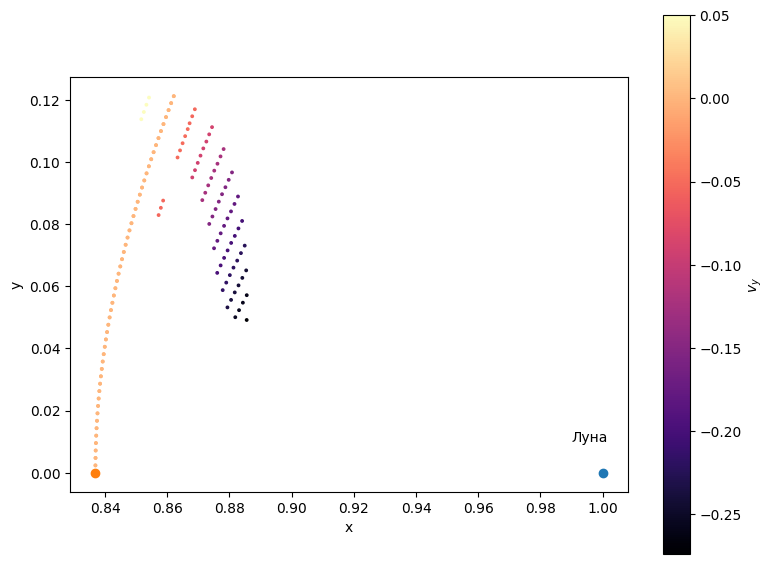

In [30]:
instruments.icm_contour_visualizer(results).show()